# dicrotic notch detection 

An algorithm to detect dicrotic notch in arterial blood
pressure and photoplethysmography waveforms using
the iterative envelope mean method

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt, find_peaks, savgol_filter
from scipy.interpolate import CubicSpline


In [604]:
sig = np.load(r"../data/processed/BP_npy/PulseDB/test_2.npy")
sig.shape

(38110, 2, 1250)

In [605]:
sig = sig[:,1,:]

Text(0.5, 1.0, 'PulseDB test_2 signal')

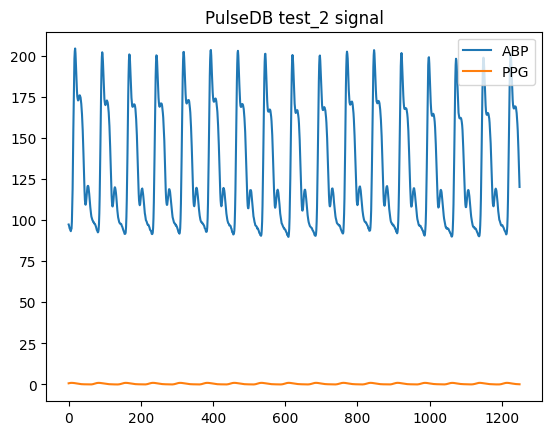

In [10]:
plt.plot(sig[0, :].transpose(), linewidth=1.5,label=["ABP", "PPG"])
plt.legend()
plt.title("PulseDB test_2 signal")

# algo

In [7]:
def preprocess_signal(signal, fs=256):
    # 除外条件チェック
    if np.any(signal <= 0):
        return None

    peaks, _ = find_peaks(signal)
    if np.sum(signal[peaks] > np.percentile(signal, 75)) <= 3:
        return None
    if len(peaks) > 10:
        return None

    # Butterworthローパスフィルタ
    b, a = butter(N=4, Wn=16/(fs/2), btype='low')
    filtered = filtfilt(b, a, signal)

    # 正規化
    y_min = np.min(filtered)
    y_max = np.max(filtered)
    if y_max - y_min == 0:
        return None
    normalized = (filtered - y_min) / (y_max - y_min)
    return normalized


def get_envelope_mean(y,y_deriv, extrema_type):
    if extrema_type == 'max':
        peaks, _ = find_peaks(y_deriv)
    else:
        peaks, _ = find_peaks(-y_deriv)

    if len(peaks) < 2:
        return np.zeros_like(y_deriv)

    cs = CubicSpline(peaks, y[peaks])
    return cs(np.arange(len(y)))


def IEM_method(y, max_iter=20, beta=0.1,fs=125):
    R_prev = np.zeros_like(y)
    m_sum = np.zeros_like(y)
    y_i = y.copy()
    window_length = int(0.2*fs/2+0.5)
    for i in range(max_iter):
        # 平滑化と微分（Savitzky-Golayフィルタ）
        y_smooth = savgol_filter(y_i, window_length=window_length, polyorder=4)
        dy = savgol_filter(y_i, window_length=window_length, polyorder=4, deriv=1)
        # ddy = savgol_filter(y_i, window_length=window_length, polyorder=4, deriv=2)
        # 上下エンベロープの取得
        upper = get_envelope_mean(y_smooth,dy, 'max')
        lower = get_envelope_mean(y_smooth,dy, 'min')
        m_i = (upper + lower) / 2
        # 非定常成分の抽出
        R_i = y_smooth - m_i
        m_sum += m_i
        # 収束判定（平均の変化量がbeta未満）
        criterion = np.abs(np.mean(R_i**2) - np.mean(R_prev**2))
        # print(f"Iteration {i+1}, Criterion: {criterion:.4f}")
        if np.abs(np.mean(R_i**2) - np.mean(R_prev**2)) < beta:
            # print(f"Converged after {i+1} iterations",)
            break
        R_prev = R_i.copy()
        y_i = R_i.copy()
    # if i == max_iter - 1:
        # print("Maximum iterations reached without convergence")
    # 最終出力：非定常成分と定常成分
    NSTS = R_i
    STS = m_sum
    return NSTS, STS


def detect_dn(NSTS, signal, fs=256):
    max_rr_interval = fs * 60 // 200 # 最大RR間隔（220bpm）
    peaks, _ = find_peaks(signal, prominence=0.2, distance=max_rr_interval)
    dn_candidates = []
    systolic_peaks = []
    window_length = int(0.2*fs/2+0.5)
    # print("window_length", window_length)
    for i in range(len(peaks) - 1):
        systolic_peak = peaks[i]
        end = peaks[i+1] if i+1 < len(peaks) else len(signal) - 1
        
        search_range = NSTS[systolic_peak+window_length:end]  # 0.1s = 25 samples
        if len(search_range) == 0:
            continue
        valleys, _ = find_peaks(-search_range)
        
        for v in valleys:
            pos = systolic_peak + window_length + v
            if NSTS[pos] < 0:
                dn_candidates.append(pos)
                systolic_peaks.append(systolic_peak)
                break

    return dn_candidates,systolic_peaks
def ceil(x):
    return int(x) if x == int(x) else int(x) + 1

Selected signal index: 8853
Preprocessed signal shape: (1250,)


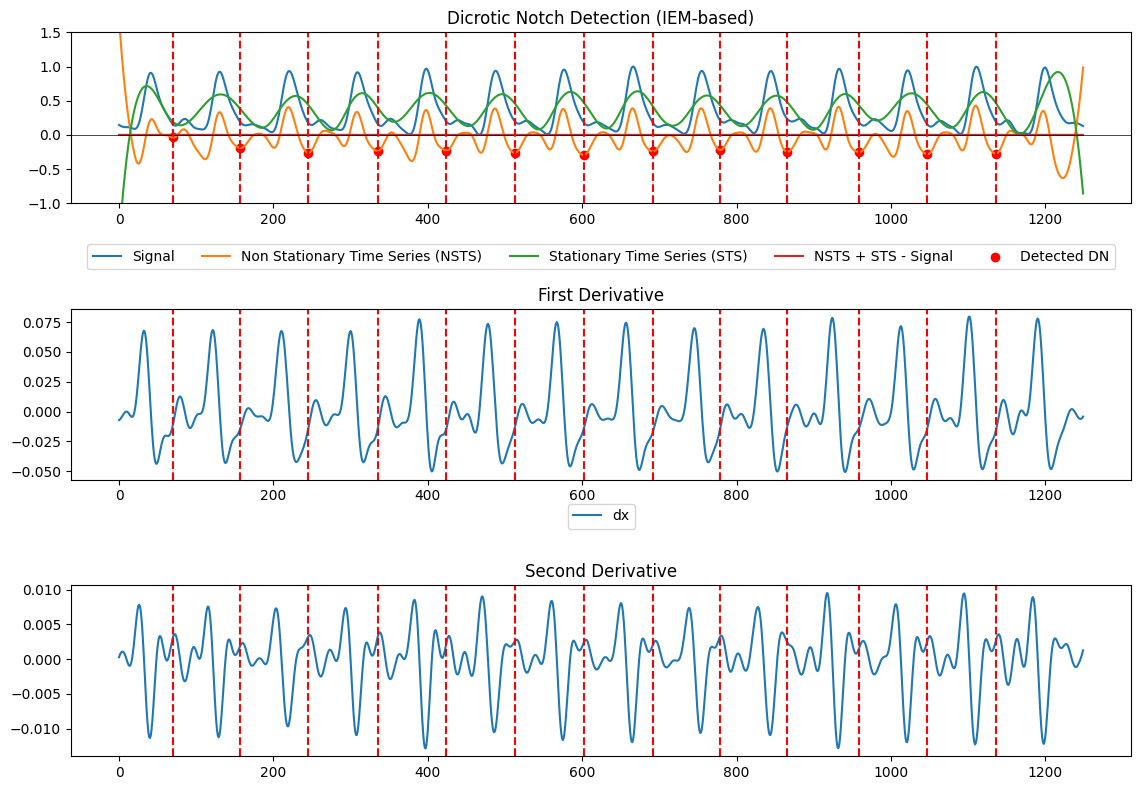

In [769]:
i = np.random.randint(0, sig.shape[0])
# i = 34383
# i = 30092
print("Selected signal index:", i)
preprocessed = sig[i]
print("Preprocessed signal shape:", preprocessed.shape)
NSTS, STS = IEM_method(preprocessed,fs=125)
dn_locations = detect_dn(NSTS, preprocessed,fs=125)
y = preprocessed.copy()
fs =125  # サンプリング周波数
max_iter = 20  # 最大反復回数
beta = 0.1  # 収束判定の閾値
R_prev = np.zeros_like(y)
m_sum = np.zeros_like(y)
y_i = y.copy()
window_length = int(0.2*fs/2+0.5)
for i in range(max_iter):
    # 平滑化と微分（Savitzky-Golayフィルタ）
    y_smooth = savgol_filter(y_i, window_length=window_length, polyorder=4)
    dy = savgol_filter(y_i, window_length=window_length, polyorder=4, deriv=1)
    ddy = savgol_filter(y_i, window_length=window_length, polyorder=4, deriv=2)
    # 上下エンベロープの取得
    upper = get_envelope_mean(y_smooth,dy, 'max')
    lower = get_envelope_mean(y_smooth,dy, 'min')
    m_i = (upper + lower) / 2
    # 非定常成分の抽出
    R_i = y_smooth - m_i
    m_sum += m_i
    # 収束判定（平均の変化量がbeta未満）
    if np.abs(np.mean(R_i**2) - np.mean(R_prev**2)) < beta:
        break
    R_prev = R_i.copy()
    y_i = R_i.copy()
# 最終出力：非定常成分と定常成分
NSTS = R_i
STS = m_sum

# plt dx, its envelopes,and  ddx 
dx = savgol_filter(preprocessed, window_length=window_length, polyorder=4, deriv=1)
ddx = savgol_filter(preprocessed, window_length=window_length, polyorder=4, deriv=2)
upper_dx = get_envelope_mean(preprocessed,dx, 'max')
lower_dx = get_envelope_mean(preprocessed,dx, 'min')
m_i = (upper + lower) / 2
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
# plt.plot(preprocessed, label='Signal')
plt.plot(preprocessed, label='Signal')
plt.plot(NSTS, label='Non Stationary Time Series (NSTS)')
plt.plot(STS, label='Stationary Time Series (STS)')
plt.plot(NSTS+STS-preprocessed,label ='NSTS + STS - Signal')
# plt.plot(lower, label='Lower Envelope of Signal ')
plt.scatter(dn_locations, NSTS[dn_locations], color='r', label='Detected DN')
plt.axhline(0, color='k', linestyle='-', linewidth=0.5)
plt.ylim(-1,1.5)
for x in dn_locations:
    plt.axvline(x=x, color='r', linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=5)
plt.title("Dicrotic Notch Detection (IEM-based)")
plt.subplot(3, 1, 2)
plt.plot(dx, label='dx')
# plt.plot(upper, label='Upper Envelope of dx')
# plt.plot(lower, label='Lower Envelope of dx')
for x in dn_locations:
    plt.axvline(x=x, color='r', linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

plt.title("First Derivative")
plt.subplot(3, 1, 3)
plt.plot(ddx, label='ddx')
for x in dn_locations:
    plt.axvline(x=x, color='r', linestyle='--')
plt.title("Second Derivative")
plt.tight_layout()

- yの振幅 A_N
- 波形全体の振幅との比　depth_ratio = (max(x) - A_N) / (max(x) - min(x))  
- ピークの微分値（スケーリング）slope_norm = slope / (max(x) - min(x))  


Selected signal index: 4234
Converged after 1 iterations


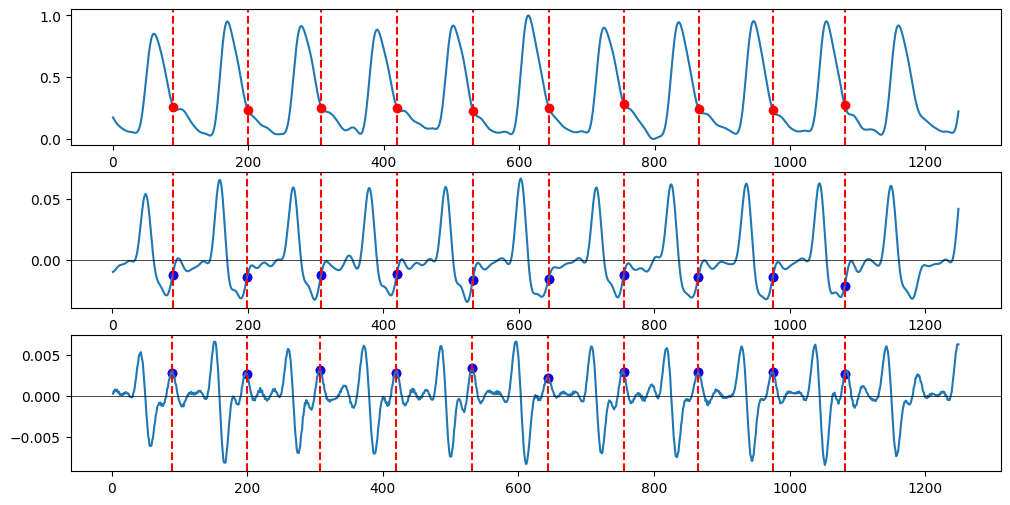

In [492]:
i = np.random.randint(0, sig.shape[0])
print("Selected signal index:", i)
y = sig[i]
dy = np.diff(y)
ddy = np.diff(dy)
NSTS, STS = IEM_method(y,fs=125)
dn_locations = detect_dn(NSTS, y,fs=125)
amplitude = y[dn_locations]
amplitude_scaled = amplitude / (np.max(y) - np.min(y))
amplitude_dy = dy[[i-1 for i in dn_locations]]
amplitude_dy_scaled = amplitude_dy / (np.max(y) - np.min(y))
amplitude_ddy = ddy[[i-2 for i in dn_locations]]  # 2つ前のインデックスを使用
amplitude_ddy_scaled = amplitude_ddy / (np.max(y) - np.min(y))
plt.figure(figsize=(12,6))
plt.subplot(3, 1, 1)
plt.plot(y, label='Signal')
plt.scatter(dn_locations, amplitude,s=2, color='r', label='Detected DN')
plt.plot(dn_locations, amplitude_scaled, 'ro', label='Amplitude (scaled)')
for x in dn_locations:
    plt.axvline(x=x, color='r', linestyle='--')
plt.subplot(3, 1, 2)
plt.plot(np.arange(1,len(y)),dy, label='First Derivative')
plt.scatter(dn_locations, amplitude_dy, color='r', label='Detected DN')
# plt.scatter(dn_locations, dy[dn_locations-1], color='green', label='Detected DN')
plt.scatter(dn_locations, amplitude_dy_scaled, color="b", label='Amplitude FD (scaled)')
plt.axhline(0, color='k', linestyle='-', linewidth=0.5)
for x in dn_locations:
    plt.axvline(x=x, color='r', linestyle='--')
plt.subplot(3, 1, 3)
plt.plot(np.arange(2,len(y)),ddy, label='Second Derivative')
plt.scatter(dn_locations, amplitude_ddy, color='r', label='Detected DN')
plt.scatter(dn_locations, amplitude_ddy_scaled, color="b", label='Amplitude FD (scaled)')
plt.axhline(0, color='k', linestyle='-', linewidth=0.5)
for x in dn_locations:
    plt.axvline(x=x, color='r', linestyle='--')

# make df

In [4]:
sig = np.load(r"../data/processed/BP_npy/PulseDB/test_2.npy")
sig = sig[:,1,:]

In [8]:
from tqdm import tqdm
import pandas as pd
def extract_features(sig):
    columns=[
        'mean_amplitude_y',
        'mean_amplitude_dy',
        'mean_amplitude_ddy',
        'peak_to_dn_distance',
        'mean_amplitude_after13_dn_dy','mean_amplitude_after5_dn_dy'
    ]
    df = pd.DataFrame(columns=columns)
    arr = np.zeros((sig.shape[0], len(columns)))  # 6列の配列を初期化
    pbar = tqdm(range(sig.shape[0]))
    for i in pbar:
        y = sig[i]
        dy = np.diff(y)
        ddy = np.diff(dy)
        NSTS, STS = IEM_method(y,fs=125)
        dn_locations,systolic_peaks = detect_dn(NSTS, y,fs=125)
        dn_locations = np.array(dn_locations)
        systolic_peaks = np.array(systolic_peaks)
        peak_to_dn_distance = dn_locations - systolic_peaks
        amplitude = y[dn_locations]
        amplitude_scaled = amplitude / (np.max(y) - np.min(y))
        amplitude_dy = dy[[i-1 for i in dn_locations]]
        # amplitude_dy_scaled = amplitude_dy / (np.max(y) - np.min(y))
        amplitude_after13_dn_dy = np.array([np.mean(dy[loc:loc+13]) for loc in dn_locations])
        amplitude_after5_dn_dy = np.array([np.mean(dy[loc:loc+5]) for loc in dn_locations])
        # outlier removal
        mean_dy = np.mean(amplitude_dy)
        std_dy = np.std(amplitude_dy)
        threshold_dy = mean_dy + 3 * std_dy
        passed_index = np.where(amplitude_dy < threshold_dy)[0]
        amplitude_ddy = ddy[[i-2 for i in dn_locations]]  # 2つ前のインデックスを使用
        # amplitude_ddy_scaled = amplitude_ddy / (np.max(y) - np.min(y))
        mean_amplitude_y = np.mean(amplitude[passed_index])
        # mean_amplitude_y_scaled = np.mean(amplitude_scaled[passed_index])
        mean_amplitude_dy = np.mean(amplitude_dy[passed_index])
        # mean_amplitude_dy_scaled = np.mean(amplitude_dy_scaled[passed_index])
        mean_amplitude_ddy = np.mean(amplitude_ddy[passed_index])
        # mean_amplitude_ddy_scaled = np.mean(amplitude_ddy_scaled[passed_index])
        mean_amplitude_after13_dn_dy = np.mean(amplitude_after13_dn_dy[passed_index])
        mean_amplitude_after5_dn_dy = np.mean(amplitude_after5_dn_dy[passed_index])
        arr[i] = [
            mean_amplitude_y, # mean_amplitude_y_scaled,
            mean_amplitude_dy, # mean_amplitude_dy_scaled,
            mean_amplitude_ddy,#  mean_amplitude_ddy_scaled,
            peak_to_dn_distance.mean(),
            mean_amplitude_after13_dn_dy,mean_amplitude_after5_dn_dy
        ]
    return arr,columns
    # pbar.set_postfix({'outliers': len(dn_locations) - len(passed_index),})

In [ ]:
columns=[
    'mean_amplitude_y',
    'mean_amplitude_dy',
    'mean_amplitude_ddy',
    'peak_to_dn_distance',
    'mean_amplitude_after13_dn_dy','mean_amplitude_after5_dn_dy'
]

In [10]:
columns

['mean_amplitude_y',
 'mean_amplitude_dy',
 'mean_amplitude_ddy',
 'peak_to_dn_distance',
 'mean_amplitude_after13_dn_dy',
 'mean_amplitude_after5_dn_dy']

In [9]:
test_data = np.load(r"../data/processed/BP_npy/PulseDB/test_2.npy")[:,1,:]
arr,columns = extract_features(test_data)
df = pd.DataFrame(arr, columns=columns)
df.to_csv("../data/processed/csv/PulseDB/ppg_dn_amplitude_test_2_2.csv")

100%|██████████| 38110/38110 [00:41<00:00, 923.95it/s] 


In [11]:
train_data = np.load(r"../data/processed/BP_npy/PulseDB/train_2.npy")
print("Train data shape:", train_data.shape)
train_data = train_data[:,1,:]

Train data shape: (312442, 2, 1250)


In [12]:
arr,columns = extract_features(train_data)

 23%|██▎       | 70439/312442 [01:13<03:57, 1018.60it/s]f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 312442/312442 [05:50<00:00, 891.36it/s] 


In [13]:
# columns=[
#     'mean_amplitude_y',
#     'mean_amplitude_dy',
#     'mean_amplitude_ddy',
#     'mean_amplitude_after13_dn_dy','mean_amplitude_after5_dn_dy'
# ]
df = pd.DataFrame(arr, columns=columns)
df.to_csv("../data/processed/csv/PulseDB/ppg_dn_amplitude_train_2_2.csv")

# XGB


In [ ]:
y_train = np.load(r"../data/processed/BP_npy/PulseDB/train_sbp_2labels.npy")
X_train = pd.read_csv("../data/processed/csv/PulseDB/ppg_dn_amplitude_train_2_2.csv", index_col=0)

X_test = pd.read_csv("../data/processed/csv/PulseDB/ppg_dn_amplitude_test_2_2.csv", index_col=0)
y_test = np.load(r"../data/processed/BP_npy/PulseDB/test_sbp_2labels.npy")
y_train.shape, X_train.shape,X_test.shape, y_test.shape

In [746]:
import xgboost as xgb
weight = np.sum(y_train)/(len(y_train) - np.sum(y_train))
clf = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight = weight,
    tree_method='gpu_hist',
    verbosity=1
)

y_train.shape, X_train.shape

((312442,), (312442, 5))

In [747]:
clf.fit(X_train, y_train)

f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
#

In [770]:
predictions = clf.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")
f1 = f1_score(y_test, predictions)
print(f"F1 Score: {f1:.4f}")
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

Accuracy: 0.7117
F1 Score: 0.6538
              precision    recall  f1-score   support

           0       0.70      0.81      0.75     20674
           1       0.73      0.60      0.65     17436

    accuracy                           0.71     38110
   macro avg       0.71      0.70      0.70     38110
weighted avg       0.71      0.71      0.71     38110

[[16743  3931]
 [ 7058 10378]]


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


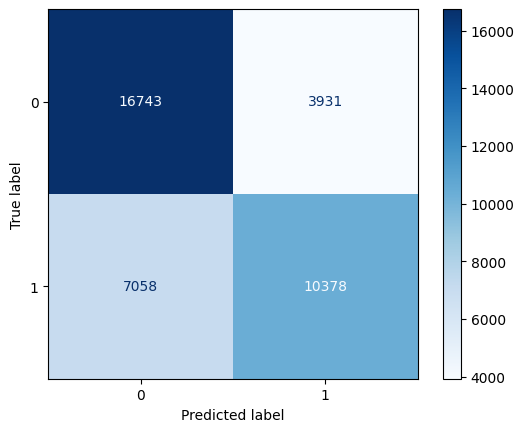

In [773]:
# plot confusion matrix with weights
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions),   
                            display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()


In [759]:
# detect nan
n_nan = np.isnan(X_train).any(axis=1)
print(f"Number of NaN rows in X_train: {np.sum(n_nan)}")
X_train = np.nan_to_num(X_train, copy=False)    

Number of NaN rows in X_train: 0


In [760]:
# linear regression
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression()
reg.fit(X_train, y_train)
predictions = reg.predict(X_test)

f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [761]:

predictions

array([0, 1, 1, ..., 0, 0, 0])

In [763]:
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")
f1 = f1_score(y_test, predictions)
print(f"F1 Score: {f1:.4f}")
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

Accuracy: 0.6152
F1 Score: 0.5344
              precision    recall  f1-score   support

           0       0.62      0.73      0.67     20674
           1       0.60      0.48      0.53     17436

    accuracy                           0.62     38110
   macro avg       0.61      0.60      0.60     38110
weighted avg       0.61      0.62      0.61     38110

[[15032  5642]
 [ 9021  8415]]


(array([5.260e+02, 2.776e+03, 5.925e+03, 9.059e+03, 8.498e+03, 5.507e+03,
        2.659e+03, 1.331e+03, 6.670e+02, 4.360e+02, 2.900e+02, 1.640e+02,
        1.290e+02, 8.400e+01, 2.600e+01, 1.800e+01, 1.100e+01, 1.000e+00,
        1.000e+00, 2.000e+00]),
 array([-2.97506918e-05,  5.80833159e-04,  1.19141701e-03,  1.80200086e-03,
         2.41258471e-03,  3.02316856e-03,  3.63375241e-03,  4.24433626e-03,
         4.85492011e-03,  5.46550397e-03,  6.07608782e-03,  6.68667167e-03,
         7.29725552e-03,  7.90783937e-03,  8.51842322e-03,  9.12900707e-03,
         9.73959092e-03,  1.03501748e-02,  1.09607586e-02,  1.15713425e-02,
         1.21819263e-02]),
 <BarContainer object of 20 artists>)

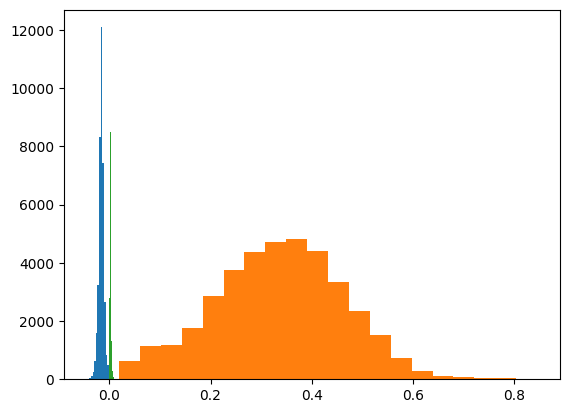

In [509]:
plt.hist(arr[:, 3], bins=20)
plt.hist(arr[:,1], bins=20)
plt.hist(arr[:, 5], bins=20)


In [519]:
sig = np.load(r"../data/processed/BP_npy/PulseDB/test_sbp_2.npy")
sig.shape

(38110,)

In [522]:
pred = np.load(r"F:\minowa\BloodPressureEstimation\repos\hydra-bp-classifier\checkpoints\resnet\0514\predictions_fold0.npy")
pred_proba = np.load(r"F:\minowa\BloodPressureEstimation\repos\hydra-bp-classifier\checkpoints\resnet\0514\predictions_proba_fold0.npy")
true = np.load(r"F:\minowa\BloodPressureEstimation\repos\hydra-bp-classifier\checkpoints\resnet\0514\true_labels_fold0.npy")

(array([1.7000e+01, 4.3900e+02, 1.8209e+04, 2.0100e+03, 5.4920e+03,
        1.0214e+04, 1.6590e+03, 5.7000e+01, 1.1000e+01, 2.0000e+00]),
 array([ 28.7558563 ,  52.12690368,  75.49795106,  98.86899844,
        122.24004582, 145.6110932 , 168.98214058, 192.35318796,
        215.72423534, 239.09528272, 262.4663301 ]),
 <BarContainer object of 10 artists>)

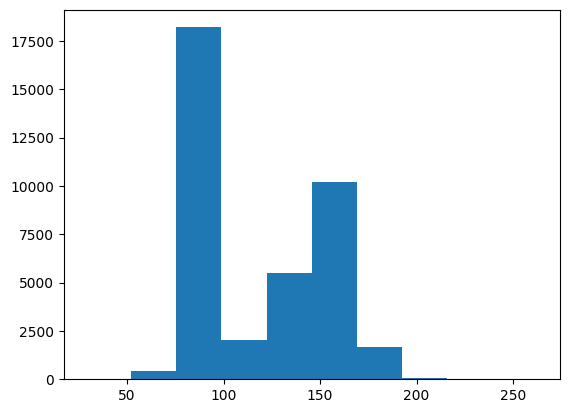

In [520]:
plt.hist(sig)

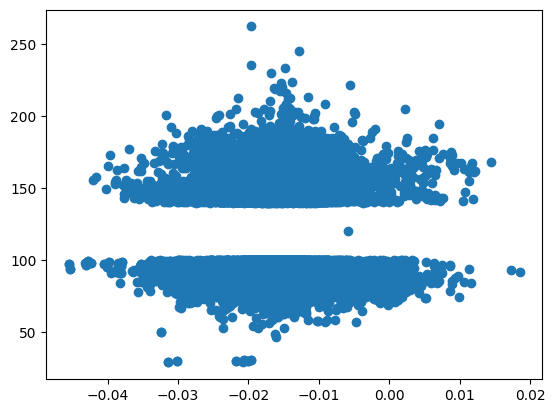

In [ ]:
plt.scatter(arr[:,3],sig)


In [527]:
len(pred), len(pred_proba), len(true    ),len(arr[:,3])

(38110, 38110, 38110, 38110)

In [534]:
# get softmax probabilities
from scipy.special import softmax 
pred_proba = softmax(pred_proba, axis=1)

In [531]:
wrong = np.where(pred != true)[0]
correct = np.where(pred == true)[0]
wrong.shape, correct.shape

((7835,), (30275,))

Text(0.5, 0, 'Amplitude of dy')

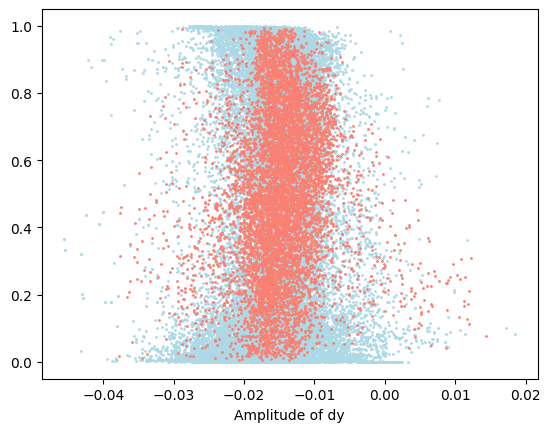

In [536]:
plt.scatter(arr[correct,3],pred_proba[correct,1],c='lightblue',s=1, label='Correct Predictions')
plt.scatter(arr[wrong,3],pred_proba[wrong,1],c='salmon',s=1,  label='Wrong Predictions')
plt.xlabel('Amplitude of dy')


## quartile

In [546]:
quartiles = np.percentile(arr[:, 3], [25, 50, 75])
# add min and max to arr
quartiles = np.concatenate(([arr[:, 3].min()-1], quartiles, [arr[:, 3].max()+1]))  # Add min and max

In [718]:
# segment data based on quartiles
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score
data_segmnted = []
for df_column in [1,3,5,6,7]:
    # print column name
    column_name = df.columns[df_column]
    print(f"Features: {column_name}")
    quartiles = np.percentile(arr[:, df_column], [25, 50, 75])
    # add min and max to arr
    quartiles = np.concatenate(([arr[:, df_column].min()-1], quartiles, [arr[:, df_column].max()+1]))
    print("Quartiles:", quartiles)
    for i in range(len(quartiles) - 1):
        lower_bound = quartiles[i]
        upper_bound = quartiles[i + 1]
        indexes = np.where((arr[:, df_column] >= lower_bound) & (arr[:, df_column] < upper_bound))[0]
        accuracy = accuracy_score(true[indexes], pred[indexes])
        f1 = f1_score(true[indexes], pred[indexes], average='macro')
        class1_ratio = np.sum(true[indexes]) / len(indexes)
        class0_ratio = 1-class1_ratio
        print(f"Quartile {i+1}: Accuracy = {accuracy:.4f}, F1 Score = {f1:.4f}, {class1_ratio:.3f}/{class0_ratio:.3f}")

Features: mean_amplitude_y_scaled
Quartiles: [-0.98047059  0.24818491  0.33760752  0.42095357  1.84469218]
Quartile 1: Accuracy = 0.8489, F1 Score = 0.7742, 0.215/0.785
Quartile 2: Accuracy = 0.7669, F1 Score = 0.7643, 0.468/0.532
Quartile 3: Accuracy = 0.8113, F1 Score = 0.8056, 0.567/0.433
Quartile 4: Accuracy = 0.7506, F1 Score = 0.7422, 0.579/0.421
Features: mean_amplitude_dy_scaled
Quartiles: [-1.04553228 -0.01817921 -0.01544215 -0.01278204  1.01851722]
Quartile 1: Accuracy = 0.8566, F1 Score = 0.8498, 0.416/0.584
Quartile 2: Accuracy = 0.7824, F1 Score = 0.7824, 0.511/0.489
Quartile 3: Accuracy = 0.7802, F1 Score = 0.7801, 0.476/0.524
Quartile 4: Accuracy = 0.7584, F1 Score = 0.7554, 0.427/0.573
Features: mean_amplitude_ddy_scaled
Quartiles: [-1.00002975  0.00182637  0.00246128  0.00318504  1.01218193]
Quartile 1: Accuracy = 0.7686, F1 Score = 0.7535, 0.384/0.616
Quartile 2: Accuracy = 0.8009, F1 Score = 0.7966, 0.430/0.570
Quartile 3: Accuracy = 0.8056, F1 Score = 0.8050, 0.526/

In [776]:
y = np.load("../data/processed/BP_npy/PulseDB/test_2.npy")[:,1,:]

In [782]:
arr.shape

(38110, 5)

Quartiles: [-1.04553228 -0.01817921 -0.01544215 -0.01278204  1.01851722]
[ 7504  7606 11586  2794]
[34063 21625 31113 13040]
[15989 12075 27585   779]
[ 4432 37644  7774 33116]


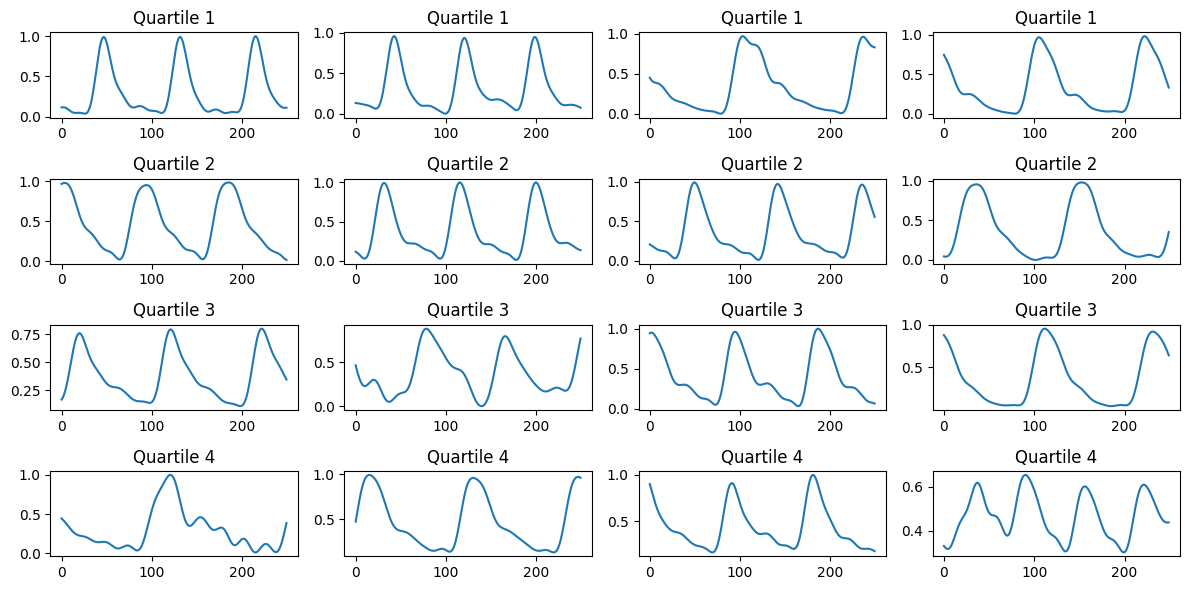

In [788]:
# get 4x4 plot
df_column = 1
quartiles = np.percentile(arr[:, df_column], [25, 50, 75])
# add min and max to arr
quartiles = np.concatenate(([arr[:, df_column].min()-1], quartiles, [arr[:, df_column].max()+1]))
print("Quartiles:", quartiles)
plt.figure(figsize=(12, 6))
for i in range(len(quartiles) - 1):
    ppg_candidate = np.where((arr[:, df_column] >= quartiles[i]) & (arr[:, df_column] < quartiles[i + 1]))[0]
    selected = np.random.choice(ppg_candidate, 4,replace=False)
    print(selected)
    for j in range(4):
        plt.subplot(4, 4, i * 4 + j + 1)
        # plot ppg
        plt.plot(y[selected[j]][:250], label='PPG Signal')
        plt.title(f'Quartile {i+1}')
plt.tight_layout()

In [544]:
arr[:,3].max()

0.018517222886657195

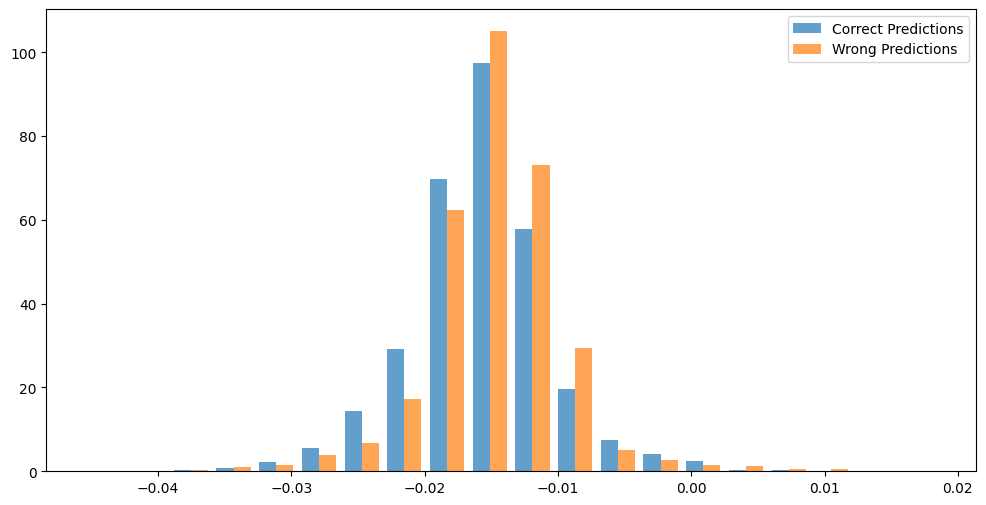

In [598]:
df_column =3
bins = np.histogram(arr[:,df_column], bins=20, density=True)
plt.figure(figsize=(12, 6))
plt.hist([arr[correct,df_column], arr[wrong,df_column]], bins=bins[1],
         label=['Correct Predictions', 'Wrong Predictions'], alpha=0.7,density=True)
plt.legend()

In [666]:
subjects = np.load(r"../data/processed/BP_npy/PulseDB/test_subjects_2.npy")
subjects.shape
np.unique(subjects).shape

(278,)

In [700]:
subject_cols = ["subject_id","n_subjects","indexes","accuracy","f1_score"]
from sklearn.metrics import accuracy_score, f1_score
subject_id = np.unique(subjects)
n_subjects = [len(np.where(subjects == s)[0]) for s in subject_id]  # Count number of data for each
subject_indexes = [np.where(subjects == s) for s in subject_id]  # Get indexes for each subject
accuracies = []
f1_scores = []
for s in np.unique(subjects):
    # print(s)
    indexes = np.where(subjects == s)[0]
    accuracy = accuracy_score(true[indexes], pred[indexes])
    f1 = f1_score(true[indexes], pred[indexes], average='macro')
    class1_num = np.sum(true[indexes])
    class0_num = len(indexes) - class1_num
    accuracies.append(accuracy)
    f1_scores.append(f1)
    print(f"Subject {s}: Number of Data = {len(indexes)}, Accuracy = {accuracy:.4f}, F1 Score = {f1:.4f}, {class0_num}/{class1_num}")

Subject 53: Number of Data = 134, Accuracy = 0.9851, F1 Score = 0.8295, 2/132
Subject 68: Number of Data = 12, Accuracy = 0.8333, F1 Score = 0.4545, 0/12
Subject 103: Number of Data = 21, Accuracy = 1.0000, F1 Score = 1.0000, 0/21
Subject 184: Number of Data = 161, Accuracy = 0.9938, F1 Score = 0.4984, 161/0
Subject 195: Number of Data = 203, Accuracy = 0.6650, F1 Score = 0.3994, 0/203
Subject 205: Number of Data = 134, Accuracy = 0.5373, F1 Score = 0.4006, 68/66
Subject 216: Number of Data = 121, Accuracy = 0.9587, F1 Score = 0.9360, 25/96
Subject 266: Number of Data = 54, Accuracy = 0.9074, F1 Score = 0.8522, 46/8
Subject 303: Number of Data = 158, Accuracy = 0.8861, F1 Score = 0.8791, 51/107
Subject 317: Number of Data = 181, Accuracy = 0.9392, F1 Score = 0.4843, 181/0
Subject 328: Number of Data = 163, Accuracy = 1.0000, F1 Score = 1.0000, 163/0
Subject 340: Number of Data = 42, Accuracy = 1.0000, F1 Score = 1.0000, 42/0
Subject 415: Number of Data = 131, Accuracy = 0.9771, F1 Scor

In [677]:
len(subject_id), len(n_subjects), len(subject_indexes), len(accuracies), len(f1_scores)

(278, 278, 278, 278, 278)

In [ ]:
df_subjects = pd.DataFrame({
    "subject_id": subject_id,
    "n_subjects": n_subjects,
    "indexes": subject_indexes, 
    "accuracy": accuracies,
    "f1_score": f1_scores
    
})
df_subjects.to_csv("../data/processed/csv/PulseDB/subject_stats.csv", index=False)

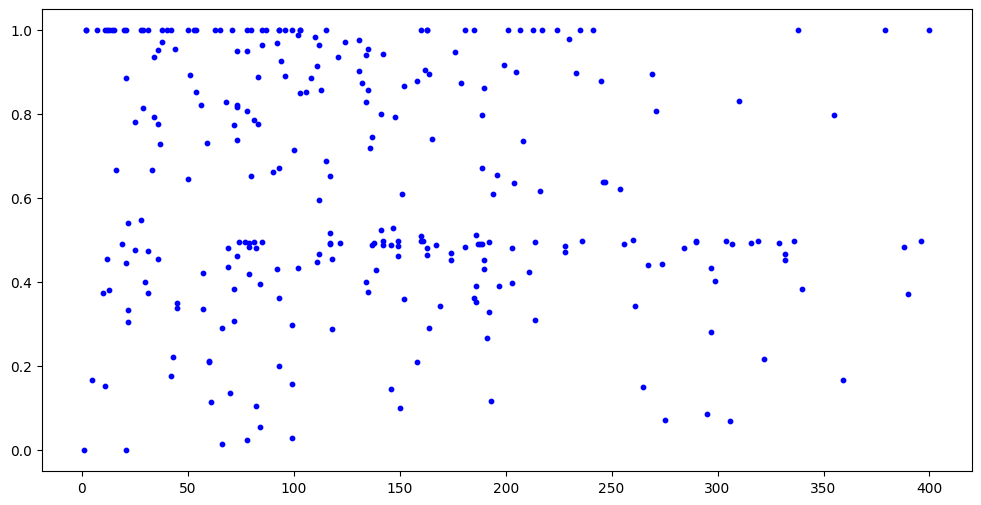

In [679]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.scatter(n_subjects,f1_scores, c='blue', s=10, label='F1 Score')

In [684]:
df.shape

(38110, 8)

In [686]:
df["subject_id"] = subjects

In [687]:
df.shape

(38110, 9)

,mean_amplitude_y,mean_amplitude_y_scaled,mean_amplitude_dy,mean_amplitude_dy_scaled,mean_amplitude_ddy,mean_amplitude_ddy_scaled,mean_amplitude_after13_dn_dy,mean_amplitude_after5_dn_dy,subject_id
0,0.275582,0.275582,-0.026717,-0.026717,0.002601,0.002601,-0.012601,-0.018658,53
1,0.374357,0.374357,-0.017153,-0.017153,0.003434,0.003434,-0.006195,-0.009427,53
2,0.369917,0.369917,-0.015520,-0.015520,0.003606,0.003606,-0.001779,-0.006158,53
3,0.374036,0.374036,-0.018228,-0.018228,0.003559,0.003559,-0.010887,-0.011809,53
4,0.397519,0.397519,-0.019012,-0.019012,0.004383,0.004383,-0.008580,-0.010051,53


In [690]:
stats = df.groupby('subject_id').agg(['mean', 'std', 'count'])
print(stats)

           mean_amplitude_y                 mean_amplitude_y_scaled            \
                       mean       std count                    mean       std   
subject_id                                                                      
53                 0.348315  0.059336   134                0.348315  0.059336   
68                 0.351202  0.080524    12                0.351202  0.080524   
103                0.412657  0.073485    21                0.412657  0.073485   
184                0.382473  0.047686   161                0.382473  0.047686   
195                0.487830  0.043840   203                0.487830  0.043840   
...                     ...       ...   ...                     ...       ...   
96338              0.437759  0.070123   117                0.437759  0.070123   
97591              0.586833  0.073257    68                0.586833  0.073257   
98759              0.332590  0.060495   111                0.332590  0.060495   
98887              0.227328 

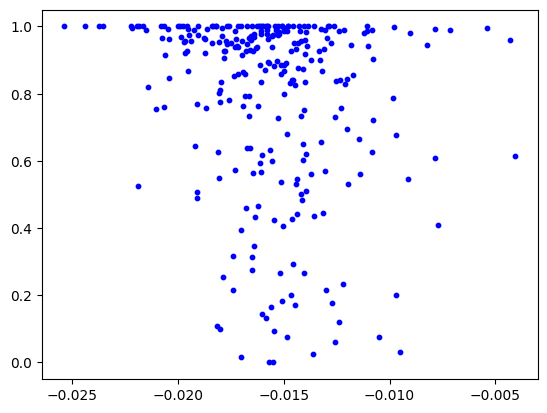

In [702]:
plt.scatter(stats['mean_amplitude_dy']['mean'], df_subjects["accuracy"], c='blue', s=10, label='Mean Amplitude y')

Text(0, 0.5, 'Accuracy')

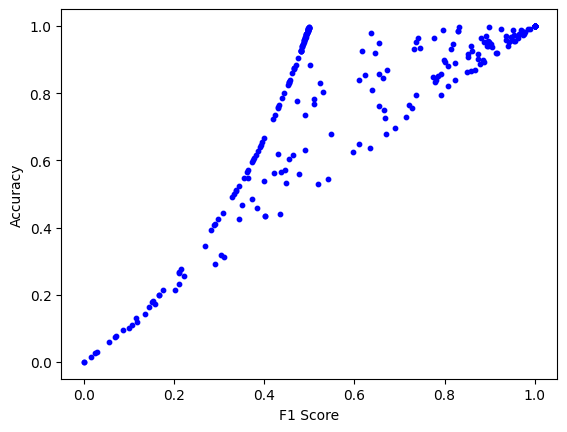

In [697]:
plt.scatter(df_subjects["f1_score"], df_subjects["accuracy"], c='blue', s=10, label='Mean Amplitude y')
plt.xlabel('F1 Score')
plt.ylabel('Accuracy') 

In [ ]:
plt.scatter(df_subjects["f1_score"], df_subjects["accuracy"], c='blue', s=10, label='Mean Amplitude y')
plt.xlabel('F1 Score')
plt.ylabel('Accuracy') 

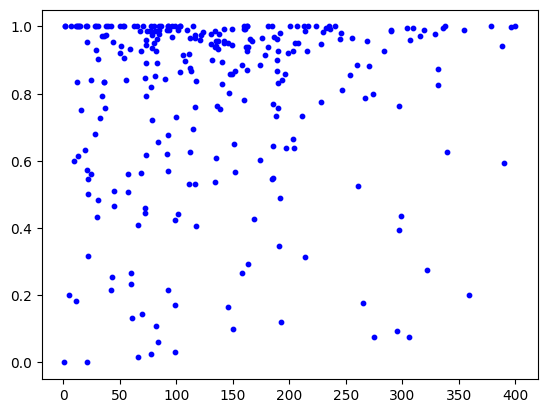

In [703]:
plt.scatter(df_subjects["n_subjects"], df_subjects["accuracy"], c='blue', s=10, label='Mean Amplitude y')

In [707]:
arr[:,3].shape

(38110,)

In [711]:
df["sbp"] = sbp

In [712]:
stats = df.groupby('subject_id').agg(['mean', 'std', 'count'])

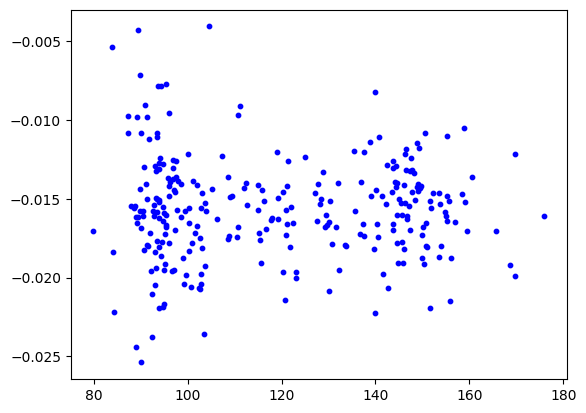

In [714]:
plt.scatter(stats['sbp']['mean'], stats['mean_amplitude_dy']['mean'], c='blue', s=10, label='Mean Amplitude y')

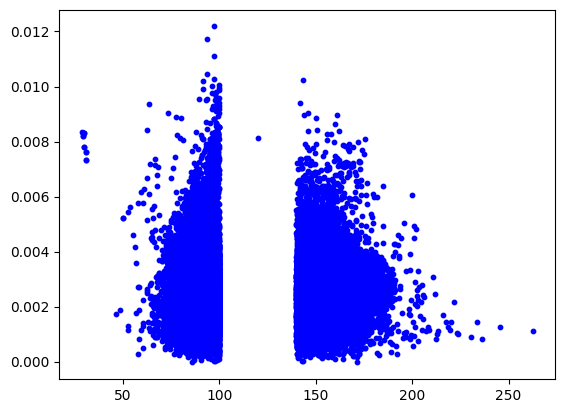

In [710]:
sbp = np.load(r"../data/processed/BP_npy/PulseDB/test_sbp_2.npy")
plt.scatter(sbp, arr[:,5], c='blue', s=10, label='Mean Amplitude y')

## XGB with only test data

In [3]:
patient_data_array = np.load(r"../data/processed/BP_npy/PulseDB/test_subjects_2.npy")

In [5]:
patient_data_array.shape

(38110,)

In [44]:
from sklearn.model_selection import GroupKFold
indices = patient_data_array[:].astype(int)  # index部分を取得
indices = indices[features_bench.signal_index]  # features_benchに基づいてindexを取得
# 1. index単位でfoldを分けるため、ユニークなindexを取得
unique_indices = np.unique(indices)
skf = GroupKFold(n_splits=5)

# index ごとのデータ数を考慮して分割
train_indexes = []
val_indexes = []
for fold, (train_index, val_idx) in enumerate(skf.split(indices, groups=indices)):
    train_indexes.append(train_index)
    val_indexes.append(val_idx)

In [45]:
patient_data_array.shape

(38110,)

In [11]:
import pandas as pd
import xgboost as xgb

In [78]:
features = pd.read_csv("../data/processed/csv/PulseDB/ppg_dn_amplitude_test_2_2.csv", index_col=0)
features_bench = pd.read_csv("../data/results/ppg_features_pulsedb_2class.csv", index_col=0)

features.shape, features_bench.shape

((38110, 6), (30518, 98))

In [74]:
features.head()

,mean_amplitude_y,mean_amplitude_dy,mean_amplitude_ddy,peak_to_dn_distance,mean_amplitude_after13_dn_dy,mean_amplitude_after5_dn_dy
0,0.275582,-0.026717,0.002601,25.625000,-0.012601,-0.018658
1,0.374357,-0.017153,0.003434,20.000000,-0.006195,-0.009427
2,0.369917,-0.015520,0.003606,19.333333,-0.001779,-0.006158
3,0.374036,-0.018228,0.003559,16.076923,-0.010887,-0.011809
4,0.397519,-0.019012,0.004383,16.142857,-0.008580,-0.010051


In [36]:
# concat features with features.index = features_bench.signal_index
features = features[features.isin(features_bench.signal_index)]

In [82]:
features_matched = features.loc[features_bench["signal_index"]].reset_index()
print(features_matched.shape)
# 結合（例：横にくっつける）
merged = pd.concat([features_bench.reset_index(drop=True), features_matched], axis=1)
merged.shape

(30518, 7)


(30518, 105)

In [83]:
merged.head()

,Tc,Ts,Td,Tsteepest,Steepest,TNegSteepest,NegSteepest,TdiaRise,DiaRise,SteepDiaRise,...,bcda,sdoo,signal_index,index,mean_amplitude_y,mean_amplitude_dy,mean_amplitude_ddy,peak_to_dn_distance,mean_amplitude_after13_dn_dy,mean_amplitude_after5_dn_dy
0,0.602667,0.199467,0.403200,0.109867,0.069232,0.282667,-0.036287,0.397333,0.251511,-0.021276,...,0.204059,0.042465,0,0,0.275582,-0.026717,0.002601,25.625000,-0.012601,-0.018658
1,0.625067,0.187733,0.437333,0.114667,0.067494,0.239467,-0.046734,0.362133,0.334255,-0.005830,...,-0.061673,0.060499,1,1,0.374357,-0.017153,0.003434,20.000000,-0.006195,-0.009427
2,0.633067,0.206933,0.426133,0.133333,0.064063,0.259733,-0.042810,0.385600,0.376757,-0.006321,...,-1.037312,0.116373,2,2,0.369917,-0.015520,0.003606,19.333333,-0.001779,-0.006158
3,0.660571,0.168571,0.492000,0.096000,0.069803,0.219429,-0.048235,0.347429,0.332146,-0.004913,...,-0.204176,0.097835,4,4,0.397519,-0.019012,0.004383,16.142857,-0.008580,-0.010051
4,0.640000,0.193714,0.446286,0.120571,0.055229,0.241714,-0.032275,0.350286,0.566382,-0.008854,...,-0.026828,0.061800,5,5,0.531073,-0.014386,0.002436,20.428571,-0.005766,-0.007951


In [37]:
features.shape

(38110, 6)

In [ ]:
features = pd.concat([features, features_bench], axis=1)


In [41]:
target = features_bench.signal_index

In [84]:
labels = np.load("../data/processed/BP_npy/PulseDB/test_sbp_2labels.npy")
labels = labels[features_bench.signal_index]
np.unique(labels),labels.shape

(array([0, 1]), (30518,))

In [17]:
features.head()

,mean_amplitude_y,mean_amplitude_dy,mean_amplitude_ddy,peak_to_dn_distance,mean_amplitude_after13_dn_dy,mean_amplitude_after5_dn_dy,Tc,Ts,Td,Tsteepest,...,T_peak_a_norm,T_peak_b_norm,T_peak_c_norm,T_peak_d_norm,T_peak_e_norm,AI,bd,bcda,sdoo,signal_index
0,0.275582,-0.026717,0.002601,25.625000,-0.012601,-0.018658,0.602667,0.199467,0.403200,0.109867,...,0.238959,0.049579,0.038129,0.054070,0.230959,0.052658,-0.006411,0.204059,0.042465,0.0
1,0.374357,-0.017153,0.003434,20.000000,-0.006195,-0.009427,0.625067,0.187733,0.437333,0.114667,...,0.216296,0.044357,0.024053,0.042041,0.161407,-0.757915,-0.009360,-0.061673,0.060499,1.0
2,0.369917,-0.015520,0.003606,19.333333,-0.001779,-0.006158,0.633067,0.206933,0.426133,0.133333,...,0.278913,0.084138,0.013043,0.033912,0.124297,-1.849847,NaN,-1.037312,0.116373,2.0
3,0.374036,-0.018228,0.003559,16.076923,-0.010887,-0.011809,0.660571,0.168571,0.492000,0.096000,...,0.190803,0.039003,0.030663,0.056752,0.163512,-0.838937,-0.008577,-0.204176,0.097835,4.0
4,0.397519,-0.019012,0.004383,16.142857,-0.008580,-0.010051,0.640000,0.193714,0.446286,0.120571,...,0.242803,0.042239,0.022199,0.046764,0.148616,-0.721334,-0.006945,-0.026828,0.061800,5.0


In [85]:
merged.drop(columns=['signal_index'], inplace=True)

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score,ConfusionMatrixDisplay


In [29]:
features_bench.shape

(30518, 98)

Fold 1:
  Number of train samples: 24415
  Number of validation samples: 6103


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


  Accuracy: 0.9994, F1 Score: 0.9994
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12408
           1       1.00      1.00      1.00     12007

    accuracy                           1.00     24415
   macro avg       1.00      1.00      1.00     24415
weighted avg       1.00      1.00      1.00     24415

[[12400     8]
 [    7 12000]]


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


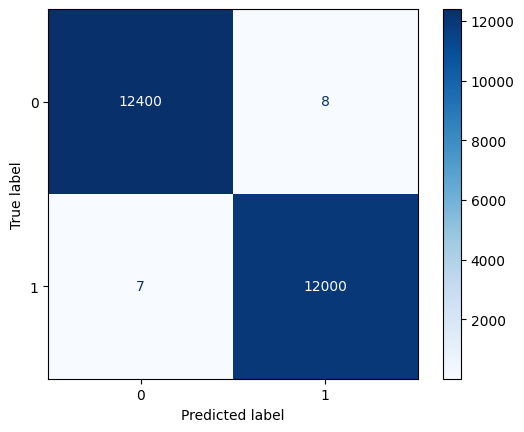

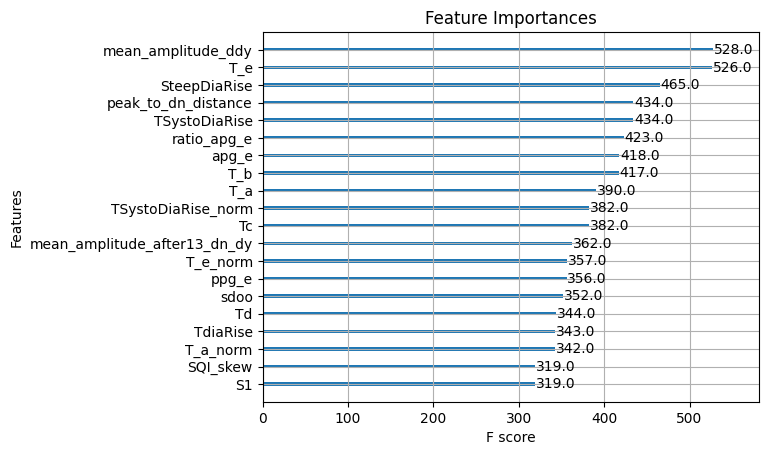

Fold 2:
  Number of train samples: 24415
  Number of validation samples: 6103


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


  Accuracy: 0.9994, F1 Score: 0.9994
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12502
           1       1.00      1.00      1.00     11913

    accuracy                           1.00     24415
   macro avg       1.00      1.00      1.00     24415
weighted avg       1.00      1.00      1.00     24415

[[12495     7]
 [    7 11906]]


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


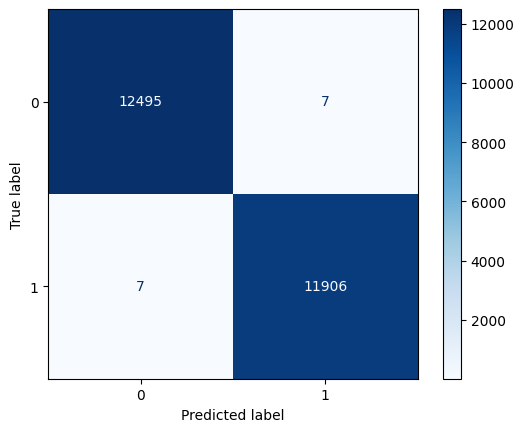

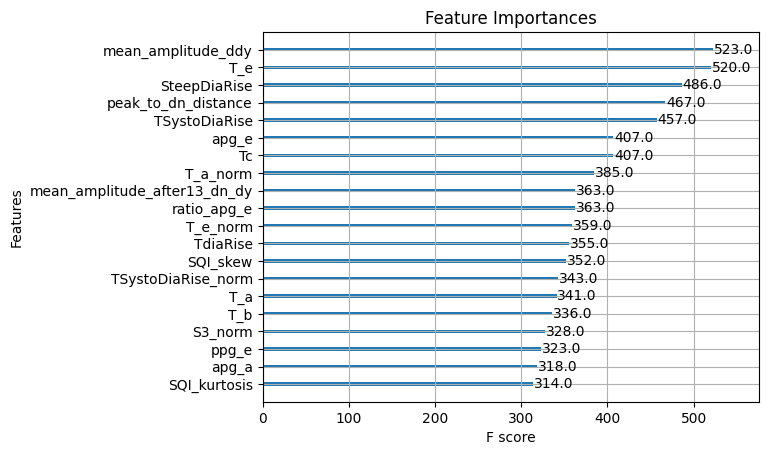

Fold 3:
  Number of train samples: 24414
  Number of validation samples: 6104


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


  Accuracy: 0.9992, F1 Score: 0.9991
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13234
           1       1.00      1.00      1.00     11180

    accuracy                           1.00     24414
   macro avg       1.00      1.00      1.00     24414
weighted avg       1.00      1.00      1.00     24414

[[13230     4]
 [   16 11164]]


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


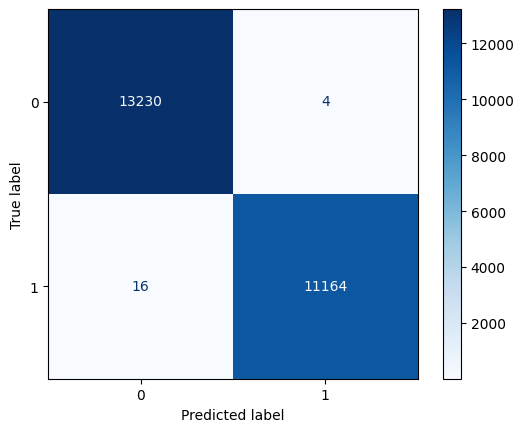

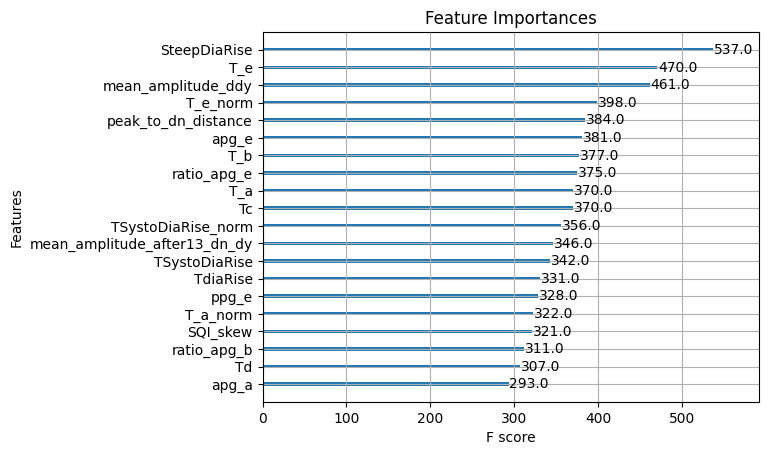

Fold 4:
  Number of train samples: 24415
  Number of validation samples: 6103


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


  Accuracy: 0.9998, F1 Score: 0.9997
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12910
           1       1.00      1.00      1.00     11505

    accuracy                           1.00     24415
   macro avg       1.00      1.00      1.00     24415
weighted avg       1.00      1.00      1.00     24415

[[12907     3]
 [    3 11502]]


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


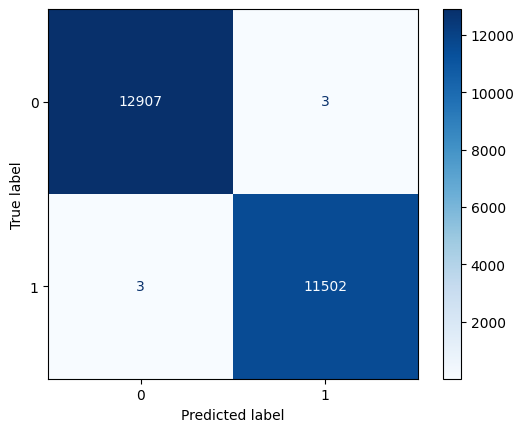

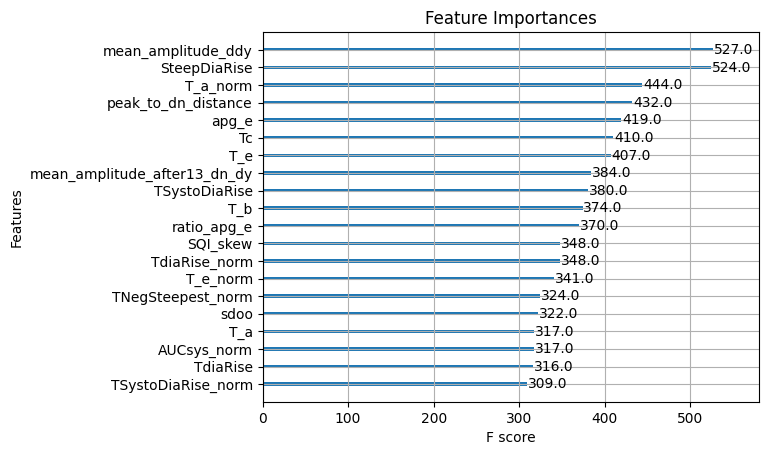

Fold 5:
  Number of train samples: 24413
  Number of validation samples: 6105


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


  Accuracy: 0.9998, F1 Score: 0.9998
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12138
           1       1.00      1.00      1.00     12275

    accuracy                           1.00     24413
   macro avg       1.00      1.00      1.00     24413
weighted avg       1.00      1.00      1.00     24413

[[12134     4]
 [    1 12274]]


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


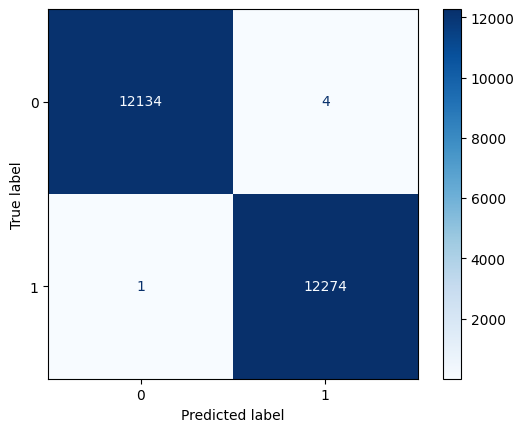

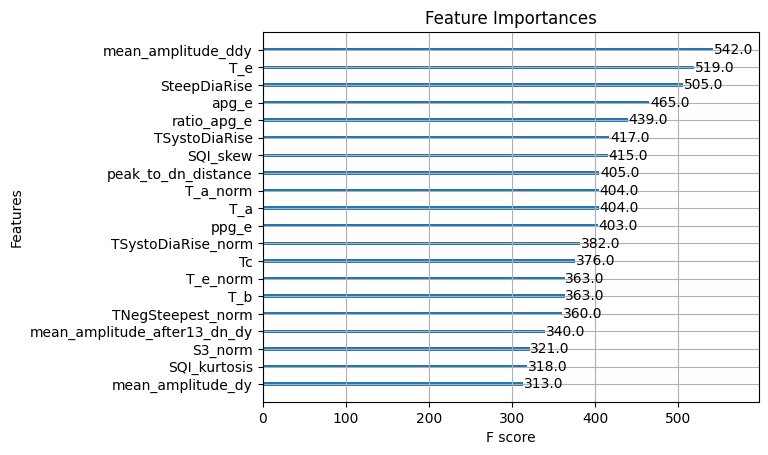

In [107]:
for f in range(5):
    print(f"Fold {f+1}:")
    print(f"  Number of train samples: {len(train_indexes[f])}")
    print(f"  Number of validation samples: {len(val_indexes[f])}")
    X_train = merged_removed.iloc[train_indexes[f]]
    y_train = labels[train_indexes[f]]
    X_val = merged_removed.iloc[val_indexes[f]]
    y_val = labels[val_indexes[f]]
    weight = np.sum(y_train)/(len(y_train) - np.sum(y_train))
    clf = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.1,
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        scale_pos_weight = weight,
        tree_method='gpu_hist',
        verbosity=1
    )
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions)
    print(f"  Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    print(classification_report(y_train, predictions))
    print(confusion_matrix(y_train, predictions))
    # plot confusion matrix with weights
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, predictions),   
                                  display_labels=clf.classes_)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.show()
    # plot feature importances
    xgb.plot_importance(clf, max_num_features=20, importance_type='weight', title='Feature Importances')
    plt.show()
    
            

In [52]:
def remove_highly_correlated_features(features, threshold=0.9, keep_features=[]):
    # 相関行列を計算
    corr_matrix = features.corr().abs()

    # 上三角部分だけを抽出
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = set()

    for col in upper.columns:
        for row in upper.index:
            if upper.loc[row, col] > threshold:
                # どちらかが優先的に残す特徴量なら、もう片方を削除候補に
                if col in keep_features:
                    to_drop.add(row)
                elif row in keep_features:
                    to_drop.add(col)
                else:
                    # 優先リストにないならどちらでも良いのでcolを削除候補に
                    to_drop.add(col)

    return features.drop(columns=to_drop), list(to_drop)

In [86]:
merged_removed,removed_list = remove_highly_correlated_features(merged, threshold=0.95, keep_features=[
        'mean_amplitude_y',
        'mean_amplitude_dy',
        'mean_amplitude_ddy',
        'peak_to_dn_distance',
        'mean_amplitude_after13_dn_dy','mean_amplitude_after5_dn_dy'
    ]) 

In [87]:
# look for nan
merged_removed.isna().sum()

Tc                              0
Ts                              0
Td                              0
Steepest                        0
NegSteepest                     0
                               ..
mean_amplitude_dy               0
mean_amplitude_ddy              0
peak_to_dn_distance             0
mean_amplitude_after13_dn_dy    0
mean_amplitude_after5_dn_dy     0
Length: 76, dtype: int64

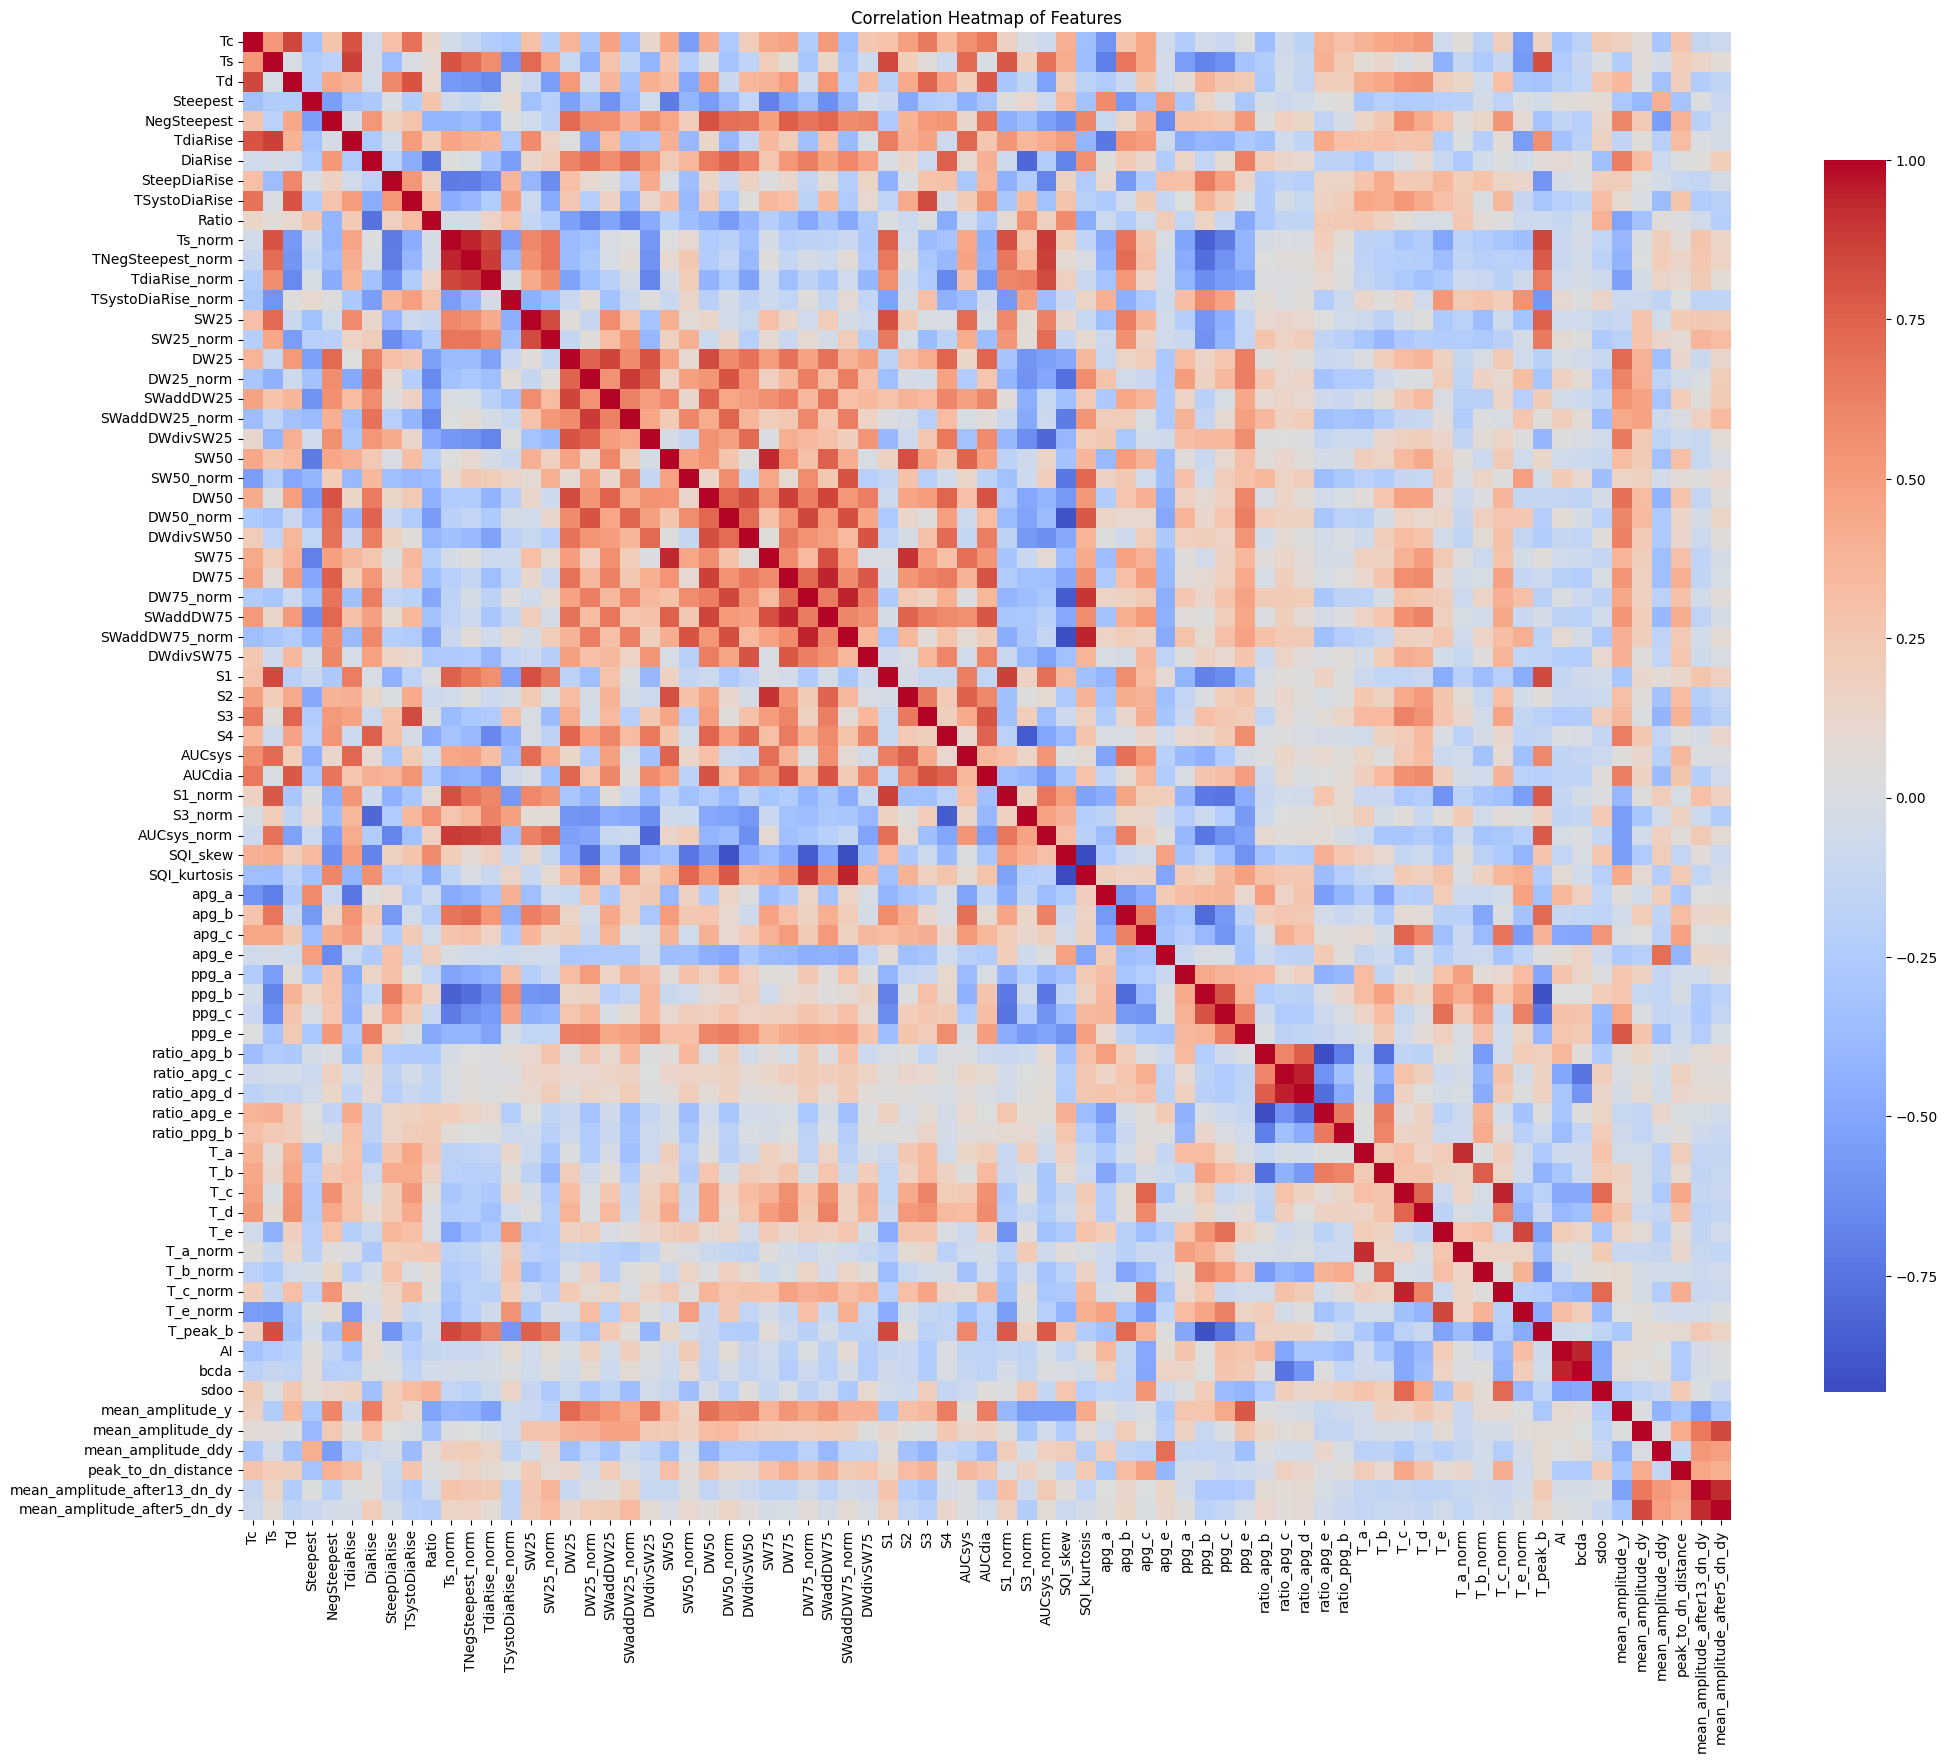

In [95]:
# plot cprr heatmap without numbers
plt.figure(figsize=(24, 20))
sns.heatmap(merged_removed.corr(), annot=False, cmap='coolwarm', square=True, cbar_kws={"shrink": .8},xticklabels=merged_removed.columns, yticklabels=merged_removed.columns)
# 軸のフォントサイズを小さくする
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Correlation Heatmap of Features')
plt.show()


In [100]:
corr_matrix = merged.corr()

In [102]:
corr_matrix.loc["peak_to_dn_distance", "T_peak_e_norm"]

0.08596108471610527

In [89]:
removed_list,len(removed_list)

(['ratio_ppg_d',
  'bd',
  'T_peak_e',
  'T_peak_b_norm',
  'Tsteepest_norm',
  'T_peak_c_norm',
  'T_d_norm',
  'T_peak_c',
  'apg_d',
  'T_peak_d',
  'TNegSteepest',
  'T_peak_d_norm',
  'T_peak_a',
  'ratio_ppg_c',
  'S2_norm',
  'T_peak_a_norm',
  'SWaddDW50_norm',
  'Tsteepest',
  'TdiaToEnd_norm',
  'T_peak_e_norm',
  'AUCdia_norm',
  'SWaddDW50',
  'Td_norm',
  'S4_norm',
  'TdiaToEnd',
  'ppg_d',
  'ratio_ppg_e',
  'SW75_norm'],
 28)

In [91]:
merged_removed.drop(columns="index",inplace=True, errors='ignore')

Fold 1:
  Number of train samples: 24415
  Number of validation samples: 6103


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


  Accuracy: 0.6983, F1 Score: 0.6831
              precision    recall  f1-score   support

           0       0.76      0.67      0.71      3390
           1       0.64      0.73      0.68      2713

    accuracy                           0.70      6103
   macro avg       0.70      0.70      0.70      6103
weighted avg       0.71      0.70      0.70      6103

[[2278 1112]
 [ 729 1984]]


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


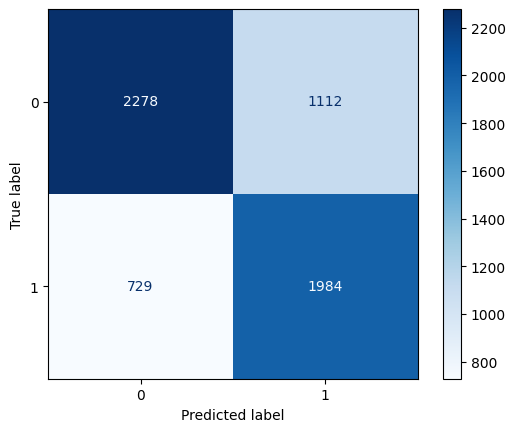

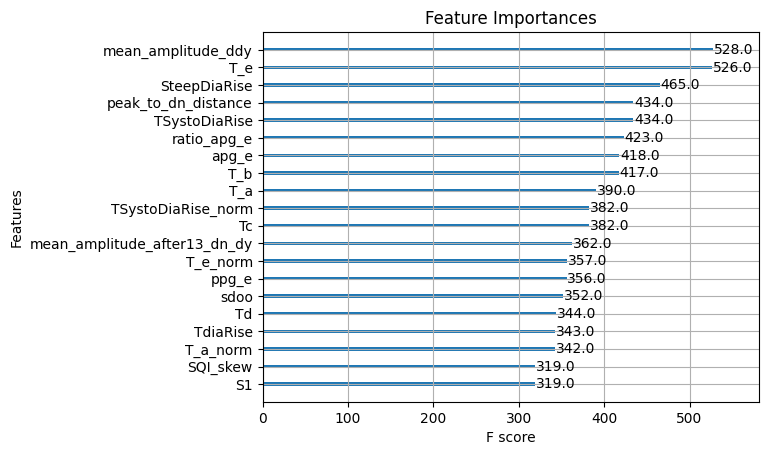

Fold 2:
  Number of train samples: 24415
  Number of validation samples: 6103


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


  Accuracy: 0.7375, F1 Score: 0.7282
              precision    recall  f1-score   support

           0       0.78      0.71      0.75      3296
           1       0.70      0.76      0.73      2807

    accuracy                           0.74      6103
   macro avg       0.74      0.74      0.74      6103
weighted avg       0.74      0.74      0.74      6103

[[2355  941]
 [ 661 2146]]


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


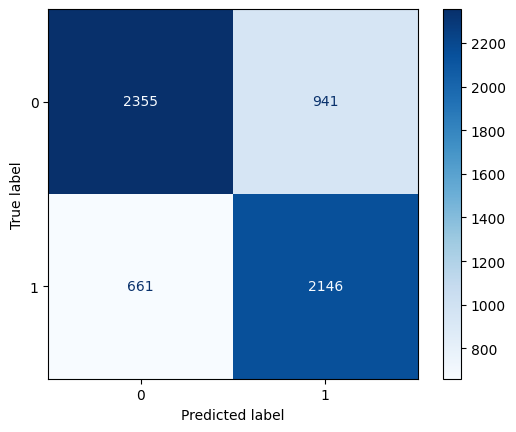

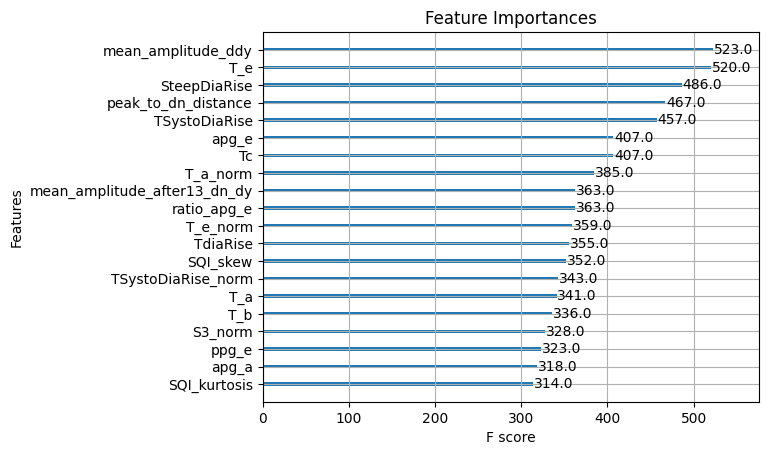

Fold 3:
  Number of train samples: 24414
  Number of validation samples: 6104


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


  Accuracy: 0.7777, F1 Score: 0.8000
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      2564
           1       0.84      0.77      0.80      3540

    accuracy                           0.78      6104
   macro avg       0.77      0.78      0.77      6104
weighted avg       0.78      0.78      0.78      6104

[[2033  531]
 [ 826 2714]]


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


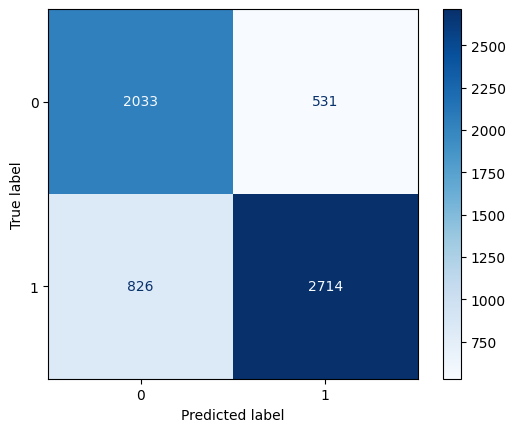

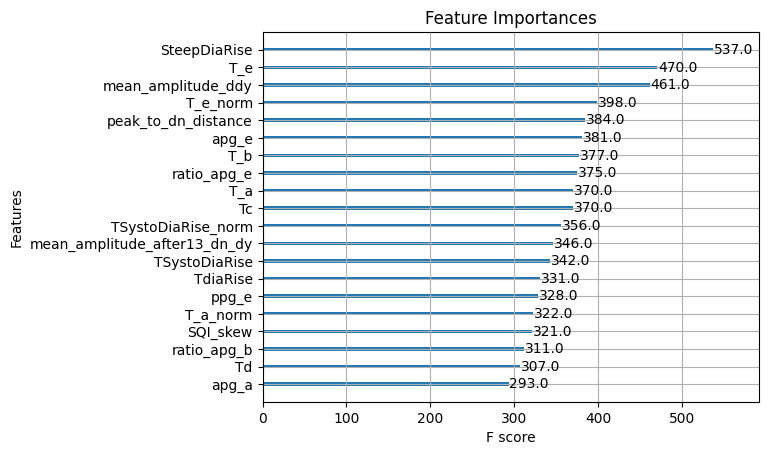

Fold 4:
  Number of train samples: 24415
  Number of validation samples: 6103


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


  Accuracy: 0.6885, F1 Score: 0.7169
              precision    recall  f1-score   support

           0       0.69      0.62      0.65      2888
           1       0.69      0.75      0.72      3215

    accuracy                           0.69      6103
   macro avg       0.69      0.69      0.69      6103
weighted avg       0.69      0.69      0.69      6103

[[1795 1093]
 [ 808 2407]]


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


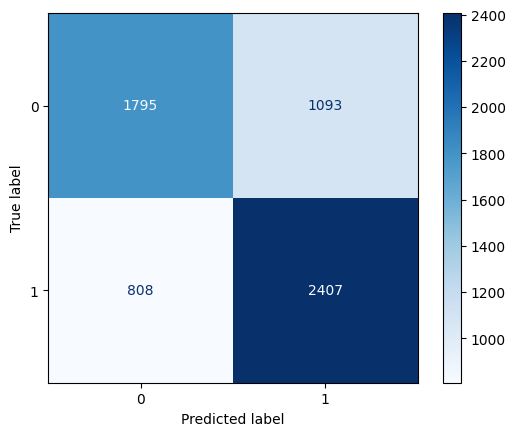

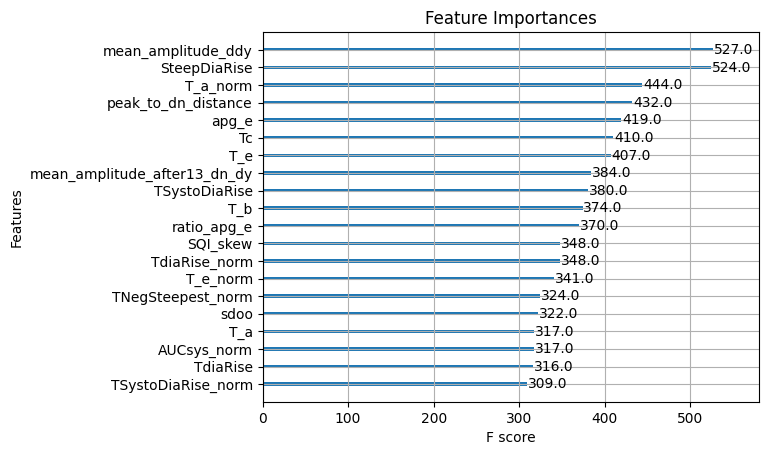

Fold 5:
  Number of train samples: 24413
  Number of validation samples: 6105


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


  Accuracy: 0.6790, F1 Score: 0.6496
              precision    recall  f1-score   support

           0       0.79      0.64      0.70      3660
           1       0.58      0.74      0.65      2445

    accuracy                           0.68      6105
   macro avg       0.68      0.69      0.68      6105
weighted avg       0.70      0.68      0.68      6105

[[2328 1332]
 [ 628 1817]]


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\xgboost\data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


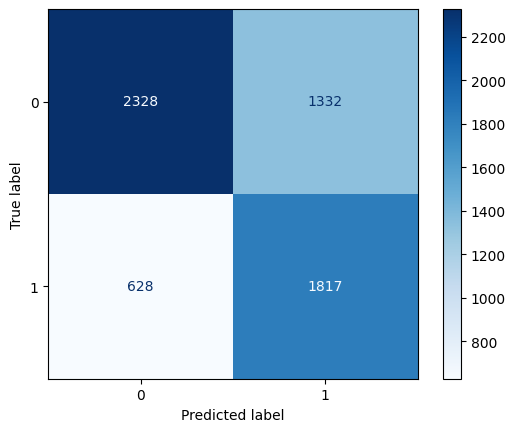

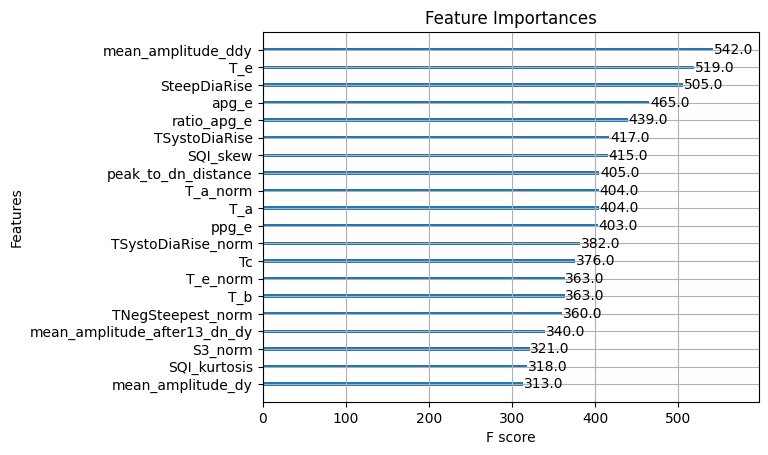

In [105]:
for f in range(5):
    print(f"Fold {f+1}:")
    print(f"  Number of train samples: {len(train_indexes[f])}")
    print(f"  Number of validation samples: {len(val_indexes[f])}")
    X_train = merged_removed.iloc[train_indexes[f]]
    y_train = labels[train_indexes[f]]
    X_val = merged_removed.iloc[val_indexes[f]]
    y_val = labels[val_indexes[f]]
    weight = np.sum(y_train)/(len(y_train) - np.sum(y_train))
    clf = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.1,
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        scale_pos_weight = weight,
        tree_method='gpu_hist',
        verbosity=1
    )
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)
    print(f"  Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    print(classification_report(y_val, predictions))
    print(confusion_matrix(y_val, predictions))
    # plot confusion matrix with weights
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, predictions),   
                                  display_labels=clf.classes_)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.show()
    # plot feature importances
    xgb.plot_importance(clf, max_num_features=20, importance_type='weight', title='Feature Importances')
    plt.show()
    
            

In [6]:
a = ['T_b',  'ratio_apg_b',  'SQI_skew',  'Td',  'SQI_kurtosis',  'S1_norm',  'TSystoDiaRise',  'SteepDiaRise',  'S2_norm',  'DWdivSW25',  'ratio_apg_e',  'apg_d',  'apg_e',  'Tc',  'bcda',  'SWaddDW75_norm',  'AUCdia',  'apg_a',  'TdiaRise',  'T_a',  'DW25',  'T_e',  'TNegSteepest',  'T_peak_e',  'TNegSteepest_norm',  'TSystoDiaRise_norm',  'T_b_norm',  'TdiaToEnd',  'DW75_norm',  'T_peak_b_norm',  'AUCsys_norm',  'T_peak_a_norm',  'T_e_norm',  'DWdivSW50',  'S1',  'SWaddDW75',  'T_d_norm',  'DW25_norm',  'T_a_norm',  'S4_norm',  'T_d',  'T_c',  'S3',  'Tsteepest_norm',  'AUCdia_norm',  'SWaddDW25',  'sdoo',  'S4',  'Tsteepest',  'DW50_norm',  'hr_0',  'ratio_ppg_e',  'SWaddDW25_norm',  'SW75_norm',  'DWdivSW75',  'Steepest',  'T_peak_e_norm',  'Ts',  'ratio_apg_c',  'ratio_apg_d',  'ppg_e',  'Ts_norm',  'SWaddDW50_norm',  'DW75',  'Ratio',  'AI',  'apg_histogram_down_6',  'cycle_zero',  'DW50',  'T_peak_d',  'ppg_b',  'NegSteepest',  'T_c_norm',  'ppg_mean_cycles_match_peak_59',  'ppg_histogram_down_0',  'AUCsys',  'T_peak_a',  'apg_histogram_down_5',  'dsdc_14',  'vpg_histogram_down_0',  'apg_c',  'vpg_min_0',  'bd',  'SW25_norm',  'ppg_histogram_down_1',  'dsdc_18',  'dsdc_3',  'ppg4_histogram_down_3',  'TdiaRise_norm',  'ppg4_histogram_down_5',  'ppg4_histogram_down_2',  'vpg_histogram_down_3',  'apg_b',  'Td_norm',  'vpg_histogram_down_2',  'SW50_norm',  'dsdc_4',  'ratio_ppg_d',  'apg_histogram_down_7',  'SWaddDW50',  'T_peak_b',  'ppg3_max_0',  'dsdc_15',  'TdiaToEnd_norm',  'ppg3_histogram_down_5',  'ppg_histogram_down_2',  'dsdc_8',  'S3_norm',  'ppg_a',  'ppg3_histogram_down_6',  'ppg4_max_neighbor_mean_0',  'ppg3_histogram_down_4',  'DiaRise',  'S2',  'T_peak_c',  'apg_histogram_down_4',  'ppg_c',  'T_peak_d_norm',  'ppg4_histogram_down_4',  'ppg4_histogram_down_8',  'ppg_histogram_down_3',  'dsdc_11',  'SW50',  'ratio_ppg_b',  'ppg3_histogram_down_9',  'ppg4_histogram_down_7',  'T_peak_c_norm',  'SW25',  'usdc_3',  'ppg4_histogram_down_6',  'dsdc_17',  'usdc_2',  'n_nan_cycle',  'vpg_max_neighbor_mean_0',  'dsdc_7',  'ppg_fft_peaks_heights_0',  'ppg3_histogram_down_7',  'ppg_histogram_down_4',  'dsdc_10',  'ppg3_histogram_up_4',  'apg_histogram_down_3',  'ppg_d',  'dsdc_6',  'dsdc_5',  'dsdc_1',  'vpg_histogram_down_1',  'dsdc_13',  'ppg_max_neighbor_mean_0',  'apg_max_neighbor_mean_0',  'dsdc_9',  'ratio_ppg_c',  'vpg_histogram_down_4',  'dsdc_16',  'ppg3_max_neighbor_mean_0',  'SW75',  'usdc_1',  'dsdc_12',  'usdc_4',  'usdc_0',  'ppg_fft_peaks_0',  'ppg4_histogram_down_1',  'dsdc_2',  'ppg3_histogram_down_8',  'ppg_fft_peaks_neighbor_avgs_0',  'usdc_5',  'ppg3_histogram_down_3',  'ppg_histogram_down_5',  'ppg4_histogram_up_4',  'ppg4_max_0',  'ppg3_histogram_down_2',  'ppg4_min_0',  'ppg_histogram_up_0',  'vpg_histogram_up_1',  'ppg4_histogram_down_9',  'dsdc_0',  'ppg3_h']

In [3]:
len(a)

176

In [9]:
a.index("ppg_fft_peaks_neighbor_avgs_0")

163